In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import squeeze_net

In [2]:
device = 'mps'


## Data loader

In [3]:
## DATA LOADER

data_dir = './dataset'
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

# The inference transforms are available at SqueezeNet1_1_Weights.IMAGENET1K_V1.transforms 
# and perform the following preprocessing operations: Accepts PIL.Image, batched (B, C, H, W) 
# and single (C, H, W) image torch.Tensor objects. The images are resized to resize_size=[256] 
# using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=[224]. 
# Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] 
# and std=[0.229, 0.224, 0.225].

imagenet1k_mean = np.array([0.485, 0.456, 0.406])
imagenet1k_std = np.array([0.229, 0.224, 0.225])

data_transforms = {
    TRAIN: transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally.
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(15),

        transforms.ToTensor(),
        transforms.Normalize(
            mean=imagenet1k_mean,
            std=imagenet1k_std
        ),
    ]),
    # VAL: transforms.Compose([
    #     transforms.Resize(256),
    #     transforms.CenterCrop(224),
    #     transforms.ToTensor(),
    # ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),

        transforms.ToTensor(),
        transforms.Normalize(
            mean=imagenet1k_mean,
            std=imagenet1k_std
        ),
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x),
        transform=data_transforms[x]
    )
    for x in [TRAIN, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=0
    )
    for x in [TRAIN, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, TEST]}

for x in [TRAIN, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))

print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 516 images under train
Loaded 31 images under test
Classes: 
['cartoon', 'closeup', 'digital', 'landscape', 'portrait']


# Utils Functions

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

def visualize_model(squeezenet, num_images=6):
    was_training = squeezenet.training

    # Set model for evaluation
    squeezenet.train(False)
    squeezenet.eval()

    images_so_far = 0

    for i, data in enumerate(dataloaders[TEST]):
        inputs, labels = data
        size = inputs.size()[0]

        with torch.no_grad():
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = squeezenet(inputs)

            _, preds = torch.max(outputs.data, 1)
            predicted_labels = [preds[j] for j in range(inputs.size()[0])]

            print("Ground truth:")
            show_databatch(inputs.data.cpu(), labels.data.cpu())
            print("Prediction:")
            show_databatch(inputs.data.cpu(), predicted_labels)

        images_so_far += size
        if images_so_far >= num_images:
            break

    squeezenet.train(mode=was_training) # Revert model back to original training state

def eval_model(squeezenet, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0

    test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 10)

    squeezenet.train(False)
    squeezenet.eval()

    with torch.no_grad():
        for i, data in enumerate(dataloaders[TEST]):
            if i % 10 == 0:
                print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)


            inputs, labels = data
            
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = squeezenet(inputs)

            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss_test += loss.data
            acc_test += torch.sum(preds == labels.data).item()

            # del inputs, labels, outputs, preds
            # torch.cuda.empty_cache()

    avg_loss = loss_test / dataset_sizes[TEST]
    avg_acc = acc_test / dataset_sizes[TEST]

    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

# Model Architecting

In [5]:
squeezenet1_1 = squeeze_net.squeezenet1_1()

squeezenet1_1.load_state_dict(models.squeezenet1_1(pretrained=True).state_dict())

print(squeezenet1_1.classifier[1].out_channels) # 1000

1000


/Users/gremlinflat/miniforge3/envs/torch_pg/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gremlinflat/miniforge3/envs/torch_pg/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# print classifer[1] Conv2d layer
print(squeezenet1_1.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1))
  (2): ReLU(inplace=True)
  (3): AdaptiveAvgPool2d(output_size=(1, 1))
)


In [7]:
# Freeze training for all layers
for param in squeezenet1_1.features.parameters():
    param.require_grad = False

In [8]:
#   (old_classifier): Sequential(
#     (0): Dropout(p=0.5)
#     (1): Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1))
#     (2): ReLU(inplace)
#     (3): AdaptiveAvgPool2d(output_size=(1, 1))
#   )
# )

# new classifier
num_features = squeezenet1_1.classifier[1].in_channels
features = list(squeezenet1_1.classifier.children())[:-3] # Remove last 3 layers
features.extend([nn.Conv2d(num_features, len(class_names), kernel_size=1)]) # Add
features.extend([nn.ReLU(inplace=True)]) # Add
features.extend([nn.AdaptiveAvgPool2d(output_size=(1,1))]) # Add

squeezenet1_1.classifier = nn.Sequential(*features) # Replace the model classifier

print("new classifier")
print(squeezenet1_1.classifier)

new classifier
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Conv2d(512, 5, kernel_size=(1, 1), stride=(1, 1))
  (2): ReLU(inplace=True)
  (3): AdaptiveAvgPool2d(output_size=(1, 1))
)


In [9]:
squeezenet1_1.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(squeezenet1_1.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Training

In [10]:
def train_model(squeezenet, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(squeezenet.state_dict())
    best_acc = 0.0

    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0

    train_batches = len(dataloaders[TRAIN])
    val_batches = len(dataloaders[TEST])

    history_loss = {
        'train': [],
        'val': []
    }

    history_acc = {
        'train': [],
        'val': []
    }

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)

        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0

        squeezenet.train(True)

        for i, data in enumerate(dataloaders[TRAIN]):
            print("\rTraining batch {}/{}".format(i, train_batches), end='', flush=True)

            inputs, labels = data

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = squeezenet(inputs)

            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            loss_train += loss.data
            acc_train += torch.sum(preds == labels.data).item()
            

            # del inputs, labels, outputs, preds
            # torch.to(device).empty_cache()

        print()

        avg_loss = loss_train / dataset_sizes[TRAIN]
        avg_acc = acc_train / dataset_sizes[TRAIN]

        squeezenet.train(False)
        squeezenet.eval()

        for i, data in enumerate(dataloaders[TEST]):
            print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)

            inputs, labels = data

            with torch.no_grad():
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                outputs = squeezenet(inputs)

                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                loss_val += loss.data
                acc_val += torch.sum(preds == labels.data).item()

                # del inputs, labels, outputs, preds
                # torch.to(device).empty_cache()

        avg_loss_val = loss_val / dataset_sizes[TEST]
        avg_acc_val = acc_val / dataset_sizes[TEST]

        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()

        history_loss['train'].append(avg_loss)
        history_loss['val'].append(avg_loss_val)

        history_acc['train'].append(avg_acc)
        history_acc['val'].append(avg_acc_val)

        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(squeezenet.state_dict())

    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))

    # return best model weights
    squeezenet.load_state_dict(best_model_wts)
    return squeezenet, history_loss, history_acc

In [11]:
EPOCH = 25
squeezenet, loss, acc = train_model(squeezenet1_1, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=EPOCH)


Epoch 0/25
----------
Training batch 64/65
Validation batch 3/4
Epoch 0 result: 
Avg loss (train): 0.1676
Avg acc (train): 0.4612
Avg loss (val): 0.1815
Avg acc (val): 0.4516
----------

Epoch 1/25
----------
Training batch 64/65
Validation batch 3/4
Epoch 1 result: 
Avg loss (train): 0.1365
Avg acc (train): 0.6124
Avg loss (val): 0.1514
Avg acc (val): 0.5806
----------

Epoch 2/25
----------
Training batch 64/65
Validation batch 3/4
Epoch 2 result: 
Avg loss (train): 0.1298
Avg acc (train): 0.6202
Avg loss (val): 0.0901
Avg acc (val): 0.7742
----------

Epoch 3/25
----------
Training batch 64/65
Validation batch 3/4
Epoch 3 result: 
Avg loss (train): 0.1246
Avg acc (train): 0.6260
Avg loss (val): 0.0848
Avg acc (val): 0.8387
----------

Epoch 4/25
----------
Training batch 64/65
Validation batch 3/4
Epoch 4 result: 
Avg loss (train): 0.1102
Avg acc (train): 0.6705
Avg loss (val): 0.0780
Avg acc (val): 0.8065
----------

Epoch 5/25
----------
Training batch 64/65
Validation batch 3/4
E

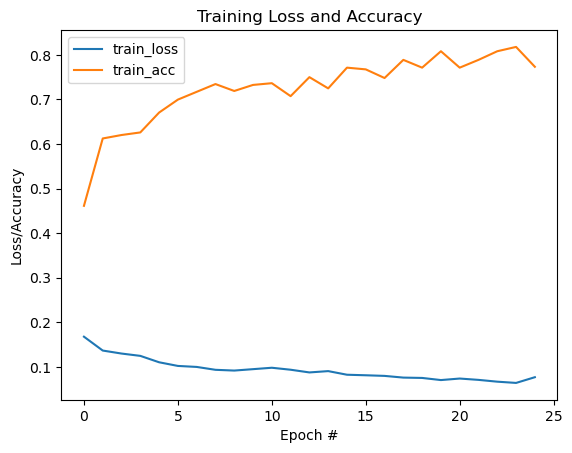

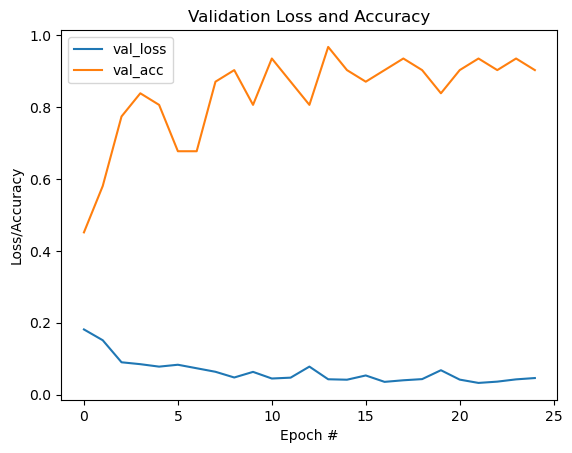

In [12]:
# convert loss and acc to cpu and numpy array
# lambda function = lambda x: x.cpu().numpy()
loss['train'] = list(map(lambda x: x.cpu().numpy(), loss['train']))
loss['val'] = list(map(lambda x: x.cpu().numpy(), loss['val']))

# visualize the training and validation (2 plots)
plt.figure()
plt.plot(np.arange(0, EPOCH), loss['train'], label='train_loss')
plt.plot(np.arange(0, EPOCH), acc['train'], label='train_acc')
plt.legend(loc='best')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.show()


plt.plot(np.arange(0, EPOCH), loss['val'], label='val_loss')
plt.plot(np.arange(0, EPOCH), acc['val'], label='val_acc')
plt.legend(loc='best')
plt.title('Validation Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.show()



# saving model

In [13]:

filename = 'squeezenet_supixel_headv1.pt'

torch.save(squeezenet.state_dict(), filename)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Ground truth:


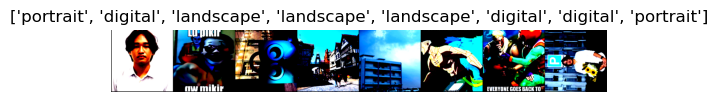

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction:


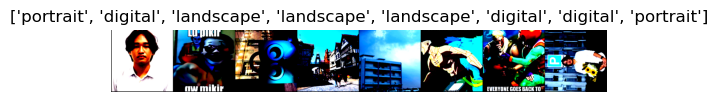

In [14]:
visualize_model(squeezenet, num_images=6)

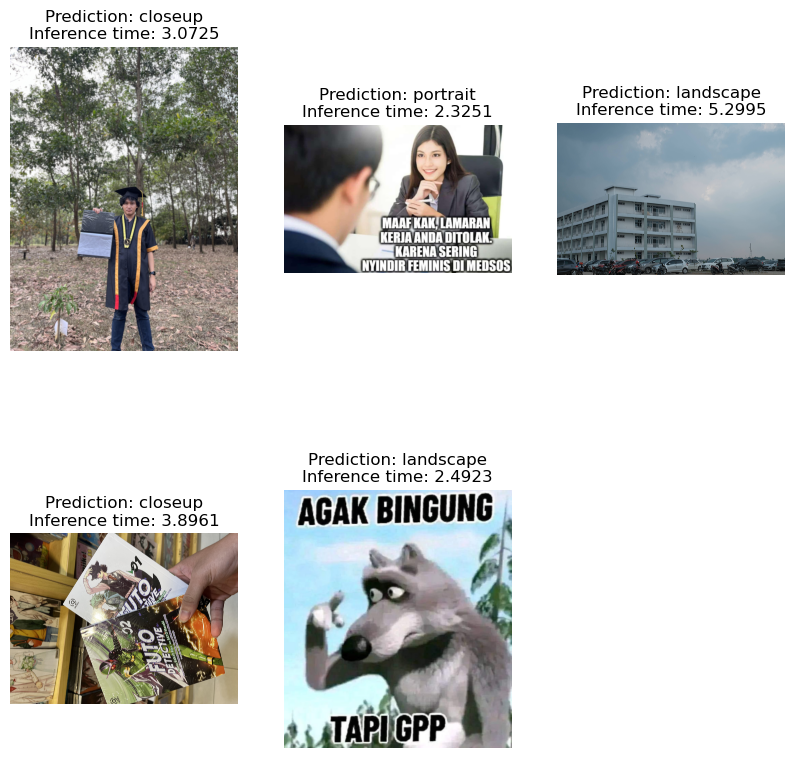


Testing completed in 0m 21s


In [15]:
# test the model on a single batch of test images
from PIL import Image

image_path = ['./dataset/train/portrait/IMG_5707.jpg', 
              './dataset/train/digital/img_1_1696312491231.jpg', 
              './dataset/test/landscape/XT207826.JPG',
              './dataset/train/closeup/70385275899__38EDE637-2ECD-4049-8F80-C13F7515E1C8.jpg',
              './dataset/test/cartoon/IMG_2226.jpg',
              ]
images = [Image.open(x) for x in image_path]

def image_transforms(image):
    # tensor_imgs = []
    tensor_img = np.array(image)
    tensor_img = tensor_img / 255.0
    tensor_img = (tensor_img - imagenet1k_mean) / imagenet1k_std
    tensor_img = tensor_img.transpose(2, 0, 1)
    tensor_img = tensor_img.astype(np.float32)

    tensor_img = torch.from_numpy(tensor_img)
    tensor_img.unsqueeze_(0)
    # tensor_imgs.append(tensor_img)

    return tensor_img

glob_since = time.time()


with torch.no_grad():
    plt.figure(figsize=(10, 10))
    # convert image to tensor
    for idx, image in enumerate(images):
        since = time.time() 
        input = image_transforms(image).to(device)
        output = squeezenet(input)
        _, preds = torch.max(output.data, 1)

        elapsed_time = time.time() - since

        # plot image, prediction and inference time
        # make 2 x 3 grid plot per image (image, prediction, inference time)
        
        plt.subplot(2, 3, idx+1)
        plt.axis('off')
        plt.imshow(image)
        plt.title('Prediction: {}\nInference time: {:.4f}'.format(class_names[preds.item()], elapsed_time))
    plt.show()
        


print()
glob_elapsed_time = time.time() - glob_since
print("Testing completed in {:.0f}m {:.0f}s".format(glob_elapsed_time // 60, glob_elapsed_time % 60))


In [16]:
# convert to onnx format
dummy_input = Variable(torch.randn(1, 3, 224, 224)).to(device)
torch.onnx.export(squeezenet, dummy_input, "squeezenet_supixel_headv1.onnx", verbose=True)


Exported graph: graph(%input.1 : Float(1, 3, 224, 224, strides=[150528, 50176, 224, 1], requires_grad=0, device=mps:0),
      %features.0.weight : Float(64, 3, 3, 3, strides=[27, 9, 3, 1], requires_grad=1, device=mps:0),
      %features.0.bias : Float(64, strides=[1], requires_grad=1, device=mps:0),
      %features.3.squeeze.weight : Float(16, 64, 1, 1, strides=[64, 1, 1, 1], requires_grad=1, device=mps:0),
      %features.3.squeeze.bias : Float(16, strides=[1], requires_grad=1, device=mps:0),
      %features.3.expand1x1.weight : Float(64, 16, 1, 1, strides=[16, 1, 1, 1], requires_grad=1, device=mps:0),
      %features.3.expand1x1.bias : Float(64, strides=[1], requires_grad=1, device=mps:0),
      %features.3.expand3x3.weight : Float(64, 16, 3, 3, strides=[144, 9, 3, 1], requires_grad=1, device=mps:0),
      %features.3.expand3x3.bias : Float(64, strides=[1], requires_grad=1, device=mps:0),
      %features.4.squeeze.weight : Float(16, 128, 1, 1, strides=[128, 1, 1, 1], requires_grad=1,

In [17]:
# image should be 3 ch and 224x224 -> optional: normalize the image
# std = [0.229, 0.224, 0.225] & mean = [0.485, 0.456, 0.406]